## Fake News Detection

## Life cycle of Machine learning Project

- Understanding the Problem Statement
- Data Collection
- Data Checks to perform
- Data Pre-Processing
- Exploratory data analysis
- Splitting Data into Train and Test Sets
- Feature Extraction and Data Transformation
- Model Training and Evaluation
- Model Tuning
- Model Selection

## 1) Problem statement
- This project predicts if a news article based on the title, text assocaited with the news and other properties.


## 2) Data Collection
- Dataset Source - https://www.kaggle.com/datasets/bhavikjikadara/fake-news-detection
- The data consists of 2 csv files true and fake
- Fake.csv -> (23481 rows, 4 columns)
- True.csv -> (21417 rows, 4 columns)
- Concatentated True and False with labels -> (44898 rows, 5 columns)

#### 2.1 Import Data and Required Packages

In [325]:
import numpy as np
import pandas as pd
import seaborn as sns
import string
import re
import spacy
from transformers import AutoTokenizer, AutoModel
import torch
import sklearn
from gensim.models import FastText
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import wordcloud
import category_encoders as ce
from textblob import TextBlob
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

#### 2.2 Import the CSV Data as Pandas DataFrame and preprocess it

In [567]:
true = pd.read_csv('/Users/mansipandya/Desktop/FakeNewsDetection/data/true.csv')
fake = pd.read_csv('/Users/mansipandya/Desktop/FakeNewsDetection/data/fake.csv')

In [568]:
true['label'] = 1
fake['label'] = 0

In [569]:
np.random.seed(42)
frames = [true.loc[:5000][:], fake.loc[:5000][:]]
df = pd.concat(frames)
df = df.sample(frac=1).reset_index(drop=True)

In [329]:
# Polarity Measures the sentiment of a text
df['polarity_title']=df['title'].apply(lambda x:TextBlob(x).sentiment.polarity)
df['polarity_text']=df['text'].apply(lambda x:TextBlob(x).sentiment.polarity)

In [570]:
# Count the occurrences of each class
class_distribution = df['label'].value_counts()

# Display the class distribution
print(class_distribution)

label
0    5001
1    5001
Name: count, dtype: int64


#### 2.3 Show Top 5 Records of Dataframe

In [330]:
df

,title,text,subject,date,label,polarity_title,polarity_text
0,Trump Threw Himself A Victory Party And Barel...,Trump s attempt at self-fellation following hi...,News,"December 2, 2016",0,0.050000,0.021354
1,Instant View: Republicans pull Obamacare repea...,(Reuters) - Republican leaders of the House of...,politicsNews,"March 24, 2017",1,0.000000,0.097494
2,U.S. judge presses Trump administration on Dre...,NEW YORK (Reuters) - A U.S. judge on Thursday ...,politicsNews,"September 21, 2017",1,0.000000,0.109117
3,House delays vote on healthcare bill: MSNBC,WASHINGTON (Reuters) - The House of Representa...,politicsNews,"March 23, 2017",1,0.000000,0.091477
4,Trump presses China on North Korea ahead of Xi...,WASHINGTON (Reuters) - U.S. President Donald T...,politicsNews,"April 2, 2017",1,0.000000,0.177094
...,...,...,...,...,...,...,...
9997,"Trump’s Salary Donation Is Just Bullsh*t PR, ...",Amateur president Donald Trump is donating his...,News,"July 26, 2017",0,0.000000,0.098452
9998,Melania Trump Hit With SERIOUS Side-Eye After...,"If you haven t noticed, no one associated with...",News,"October 24, 2017",0,-0.208333,-0.009736
9999,White Supremacist Marine Kicked Out Of The Co...,"The best way to not get fired, get kicked out ...",News,"September 13, 2017",0,0.000000,0.071164
10000,Republican tax plan would deal financial hit t...,WASHINGTON (Reuters) - The Republican tax plan...,politicsNews,"November 2, 2017",1,0.000000,0.089289


#### 2.4 Shape of the dataset

In [331]:
df.shape

(10002, 7)

#### 2.5 Dataset information

- title : News Title
- text : Text Associated with the news
- subject : Subject corresponding to the news
- date : Date the news was posted
- label : If the news is true (1) or fake (0)
- Polarity Text - Measures how negative or positive the text associated with title is
- Polarity Title - Measures how negative or positive the title associated with title is

## 3) Data Checks to perform

- Check Missing values
- Check Duplicates
- Check data type
- Check the number of unique values of each column

#### 3.1 Check Missing values

In [332]:
df.isna().sum()

title             0
text              0
subject           0
date              0
label             0
polarity_title    0
polarity_text     0
dtype: int64

There are no missing values in the dataset

#### 3.2 Check Duplicates

In [333]:
df.duplicated().sum()
df.drop_duplicates(keep='first', inplace=True)  # Keep the first occurrence

We deleted the rows that were duplicates keeping the first one of the duplicates.

#### 3.3 Check data types

In [334]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9967 entries, 0 to 10001
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           9967 non-null   object 
 1   text            9967 non-null   object 
 2   subject         9967 non-null   object 
 3   date            9967 non-null   object 
 4   label           9967 non-null   int64  
 5   polarity_title  9967 non-null   float64
 6   polarity_text   9967 non-null   float64
dtypes: float64(2), int64(1), object(4)
memory usage: 622.9+ KB


All the columns with object datatypes will be needed to be dealt with before putting them as input into an ML Model.

In [335]:
# define numerical & categorical columns
numeric_features = [feature for feature in df.columns if df[feature].dtype != 'O']
categorical_features = [feature for feature in df.columns if df[feature].dtype == 'O']

# print columns
print('We have {} numerical features : {}'.format(len(numeric_features), numeric_features))
print('\nWe have {} categorical features : {}'.format(len(categorical_features), categorical_features))

We have 3 numerical features : ['label', 'polarity_title', 'polarity_text']

We have 4 categorical features : ['title', 'text', 'subject', 'date']


#### 3.4 Checking the number of unique values of each column

In [336]:
df.nunique()

title             9956
text              9964
subject              2
date               787
label                2
polarity_title     634
polarity_text     9260
dtype: int64

## 4) Data Preprocessing

- Lowercasing the text
- Remove Digits and words contianing Digits
- Remove Punctuation
- Remove White Spaces
- Stopword Removal and Lemmatization
- Create Document Term Matrix
- Applying this transformation to remaining columns

#### 4.1 Lowercasing the text

In [338]:
df['title']=df['title'].apply(lambda x: x.lower())

#### 4.2 Remove Digits and Words Containing Digits

In [339]:
df['title']=df['title'].apply(lambda x: re.sub('\w*\d\w*','', x))

#### 4.3 Remove Punctuation

In [340]:
# Removing Punctuations
df['title']=df['title'].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '', x))

#### 4.4 Remove White Spaces

In [341]:
# Removing extra spaces
df['title']=df['title'].apply(lambda x: re.sub(' +',' ',x))

#### 4.5 Stopwords Removal and Lemmatization

In [150]:
# Loading model
nlp = spacy.load('en_core_web_sm',disable=['parser', 'ner'])

# Lemmatization with stopwords removal
df['title']=df['title'].apply(lambda x: ' '.join([token.lemma_ for token in list(nlp(x)) if (token.is_stop==False)]))

#### 4.6 Applying this transformation to 'text' column

In [342]:
def text_transformation(column_name):
    df[column_name]=df[column_name].apply(lambda x: x.lower())
    df[column_name]=df[column_name].apply(lambda x: re.sub('\w*\d\w*','', x))
    df[column_name]=df[column_name].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '', x))
    df[column_name]=df[column_name].apply(lambda x: re.sub(' +',' ',x))
    df[column_name]=df[column_name].apply(lambda x: ' '.join([token.lemma_ for token in list(nlp(x)) if (token.is_stop==False)]))
    return df

In [343]:
df = text_transformation('text')

In [344]:
df

,title,text,subject,date,label,polarity_title,polarity_text
0,trump threw himself a victory party and barel...,trump s attempt selffellation follow kindasort...,News,"December 2, 2016",0,0.050000,0.021354
1,instant view republicans pull obamacare repeal...,reuter republican leader house representative ...,politicsNews,"March 24, 2017",1,0.000000,0.097494
2,us judge presses trump administration on dream...,new york reuter judge thursday repeatedly pres...,politicsNews,"September 21, 2017",1,0.000000,0.109117
3,house delays vote on healthcare bill msnbc,washington reuter house representative thursda...,politicsNews,"March 23, 2017",1,0.000000,0.091477
4,trump presses china on north korea ahead of xi...,washington reuter president donald trump hold ...,politicsNews,"April 2, 2017",1,0.000000,0.177094
...,...,...,...,...,...,...,...
9997,trump’s salary donation is just bullsht pr an...,amateur president donald trump donate secondqu...,News,"July 26, 2017",0,0.000000,0.098452
9998,melania trump hit with serious sideeye after ...,haven t notice associate trump administration ...,News,"October 24, 2017",0,-0.208333,-0.009736
9999,white supremacist marine kicked out of the co...,good way fire kick school boot military nazi n...,News,"September 13, 2017",0,0.000000,0.071164
10000,republican tax plan would deal financial hit t...,washington reuter republican tax plan unveil t...,politicsNews,"November 2, 2017",1,0.000000,0.089289


In [345]:
df.to_pickle('/Users/mansipandya/Desktop/FakeNewsDetection/data/dataframes/df.pkl')

In [346]:
df = pd.read_pickle('/Users/mansipandya/Desktop/FakeNewsDetection/data/dataframes/df.pkl')

In [348]:
df

,title,text,subject,date,label,polarity_title,polarity_text
0,trump threw himself a victory party and barel...,trump s attempt selffellation follow kindasort...,News,"December 2, 2016",0,0.050000,0.021354
1,instant view republicans pull obamacare repeal...,reuter republican leader house representative ...,politicsNews,"March 24, 2017",1,0.000000,0.097494
2,us judge presses trump administration on dream...,new york reuter judge thursday repeatedly pres...,politicsNews,"September 21, 2017",1,0.000000,0.109117
3,house delays vote on healthcare bill msnbc,washington reuter house representative thursda...,politicsNews,"March 23, 2017",1,0.000000,0.091477
4,trump presses china on north korea ahead of xi...,washington reuter president donald trump hold ...,politicsNews,"April 2, 2017",1,0.000000,0.177094
...,...,...,...,...,...,...,...
9997,trump’s salary donation is just bullsht pr an...,amateur president donald trump donate secondqu...,News,"July 26, 2017",0,0.000000,0.098452
9998,melania trump hit with serious sideeye after ...,haven t notice associate trump administration ...,News,"October 24, 2017",0,-0.208333,-0.009736
9999,white supremacist marine kicked out of the co...,good way fire kick school boot military nazi n...,News,"September 13, 2017",0,0.000000,0.071164
10000,republican tax plan would deal financial hit t...,washington reuter republican tax plan unveil t...,politicsNews,"November 2, 2017",1,0.000000,0.089289


## 5) Exploratory data analysis

#### 5.1 Create Document Matrix for Word CLoud

In [349]:
def create_doc_matrix(target_column,text_column):
    df_grouped=df[[target_column,text_column]].groupby(by=target_column).agg(lambda x:' '.join(x))
    cv=CountVectorizer(analyzer='word')
    data=cv.fit_transform(df_grouped[text_column])
    df_dtm = pd.DataFrame(data.toarray(), columns=cv.get_feature_names_out())
    df_dtm.index=df_grouped.index
    return df_dtm

In [355]:
df_dtm_title_subject = create_doc_matrix('subject','title')
df_dtm_title_subject.to_pickle('/Users/mansipandya/Desktop/FakeNewsDetection/data/dataframes/df_dtm_title_subject.pkl')
df_dtm_title_subject = pd.read_pickle('/Users/mansipandya/Desktop/FakeNewsDetection/data/dataframes/df_dtm_title_subject.pkl')
df_dtm_title_subject

,aar,abadi,abandon,abandoned,abandoning,abandons,abbas,abc,abducted,abdullah,...,zhong,zika,zilch,zings,zinkes,zit,zone,zones,zoo,zuckerberg
subject,,,,,,,,,,,,,,,,,,,,,
News,0,0,5,2,3,0,0,2,0,0,...,0,2,1,1,0,1,0,0,1,3
politicsNews,1,2,2,0,2,1,1,7,1,2,...,1,0,0,0,1,0,2,1,0,0


In [354]:
df_dtm_text_subject = create_doc_matrix('subject','text')
df_dtm_text_subject.to_pickle('/Users/mansipandya/Desktop/FakeNewsDetection/data/dataframes/df_dtm_text_subject.pkl')
df_dtm_text_subject = pd.read_pickle('/Users/mansipandya/Desktop/FakeNewsDetection/data/dataframes/df_dtm_text_subject.pkl')
df_dtm_text_subject

,aa,aaa,aaaaackkk,aaaarrgh,aaccorde,aaf,aafter,aai,aaja,aalbert,...,zuppello,zyklon,zyprie,zyrie,zz,zzbluecomet,zztaine,zzzzaaaacccchhh,zzzzzzzzzzzzz,émigré
subject,,,,,,,,,,,,,,,,,,,,,
News,1,2,1,1,1,0,1,1,1,0,...,1,1,0,0,1,1,1,3,1,0
politicsNews,0,2,0,0,0,6,0,1,0,1,...,0,0,1,1,0,0,0,0,0,1


In [357]:
df_dtm_title_label = create_doc_matrix('label','title')
df_dtm_title_label.to_pickle('/Users/mansipandya/Desktop/FakeNewsDetection/data/dataframes/df_dtm_title_label.pkl')
df_dtm_title_label = pd.read_pickle('/Users/mansipandya/Desktop/FakeNewsDetection/data/dataframes/df_dtm_title_label.pkl')
df_dtm_title_label

,aar,abadi,abandon,abandoned,abandoning,abandons,abbas,abc,abducted,abdullah,...,zhong,zika,zilch,zings,zinkes,zit,zone,zones,zoo,zuckerberg
label,,,,,,,,,,,,,,,,,,,,,
0,0,0,5,2,3,0,0,2,0,0,...,0,2,1,1,0,1,0,0,1,3
1,1,2,2,0,2,1,1,7,1,2,...,1,0,0,0,1,0,2,1,0,0


In [356]:
df_dtm_text_label = create_doc_matrix('label','text')
df_dtm_text_label.to_pickle('/Users/mansipandya/Desktop/FakeNewsDetection/data/dataframes/df_dtm_text_label.pkl')
df_dtm_text_label = pd.read_pickle('/Users/mansipandya/Desktop/FakeNewsDetection/data/dataframes/df_dtm_text_label.pkl')
df_dtm_text_label

,aa,aaa,aaaaackkk,aaaarrgh,aaccorde,aaf,aafter,aai,aaja,aalbert,...,zuppello,zyklon,zyprie,zyrie,zz,zzbluecomet,zztaine,zzzzaaaacccchhh,zzzzzzzzzzzzz,émigré
label,,,,,,,,,,,,,,,,,,,,,
0,1,2,1,1,1,0,1,1,1,0,...,1,1,0,0,1,1,1,3,1,0
1,0,2,0,0,0,6,0,1,0,1,...,0,0,1,1,0,0,0,0,0,1


#### 5.2 Loading Pickle Files of Cleaned Data

In [358]:
df_dtm_title_subject = pd.read_pickle('/Users/mansipandya/Desktop/FakeNewsDetection/data/dataframes/df_dtm_title_subject.pkl')
df_dtm_title_label = pd.read_pickle('/Users/mansipandya/Desktop/FakeNewsDetection/data/dataframes/df_dtm_title_label.pkl')
df_dtm_text_subject = pd.read_pickle('/Users/mansipandya/Desktop/FakeNewsDetection/data/dataframes/df_dtm_text_subject.pkl')
df_dtm_text_label = pd.read_pickle('/Users/mansipandya/Desktop/FakeNewsDetection/data/dataframes/df_dtm_text_label.pkl')

#### 5.3 WordCloud

In [168]:

# Importing wordcloud for plotting word clouds and textwrap for wrapping longer text
from wordcloud import WordCloud
from textwrap import wrap

def generate_wordcloud(data, title, ax):
    wc = WordCloud(width=400, height=330, max_words=150, colormap="Dark2").generate_from_frequencies(data)
    ax.imshow(wc, interpolation='bilinear')
    ax.axis("off")
    if title==0 or title==1:
        if title == 0:
            ax.set_title("True News (1)", fontsize=13)
        else:
            ax.set_title("Fake News (0)", fontsize=13)
    else:
        ax.set_title('\n'.join(wrap(title, 60)), fontsize=13)
  
df_dtm_title=df_dtm_title_subject.transpose()
df_dtm_text=df_dtm_text_subject.transpose()
df_dtm_title_label=df_dtm_text_label.transpose()
df_dtm_text_label=df_dtm_text_label.transpose()

subjects = []
for index, subject in enumerate(df_dtm_title.columns):
    subjects.append(subject)

labels = []
for index, label in enumerate(df_dtm_title_label.columns):
    labels.append(label)


In [169]:
print(subjects)
print(labels)

['News', 'politicsNews']
[0, 1]


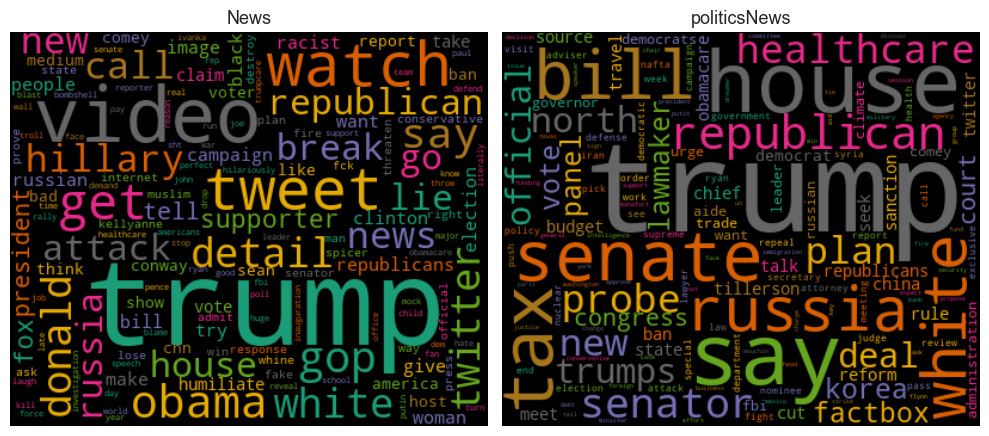

In [170]:
fig, axes = plt.subplots(1, 2, figsize=(10, 8))
k = 0

for i in range(0,1):
    for j in range(0,2):
        generate_wordcloud(df_dtm_title[subjects[k]].sort_values(ascending=False), subjects[k], axes[j])
        k+=1

plt.tight_layout()
plt.show()


Here, we can see that Trump, Video, etc are words that appear in both News and politicsNews

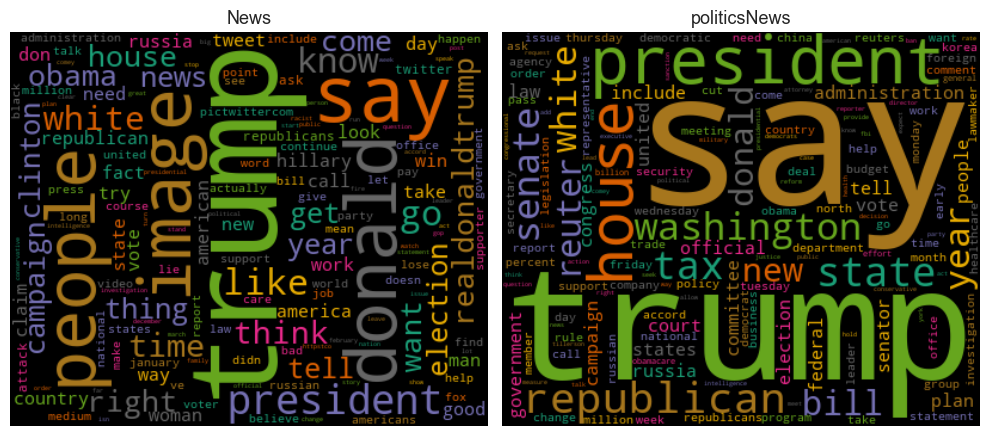

In [171]:
fig, axes = plt.subplots(1, 2, figsize=(10, 8))

k = 0
for i in range(0,1):
    for j in range(0,2):
        generate_wordcloud(df_dtm_text[subjects[k]].sort_values(ascending=False), subjects[k], axes[j])
        k+=1
plt.tight_layout()
plt.show()

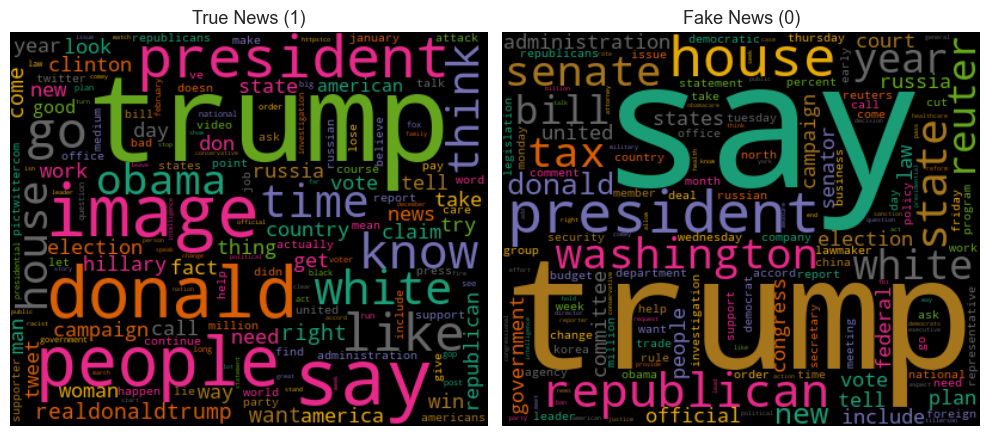

In [172]:
fig, axes = plt.subplots(1, 2, figsize=(10, 8))
k = 0
for i in range(0,1):
    for j in range(0,2):
        generate_wordcloud(df_dtm_title_label[labels[k]].sort_values(ascending=False), labels[k], axes[j])
        k+=1
axes = axes.flatten()
plt.tight_layout()
plt.show()

We can see most of the Fake News titles are revolved around "trump","president". True News mentions "clinton", "obama"

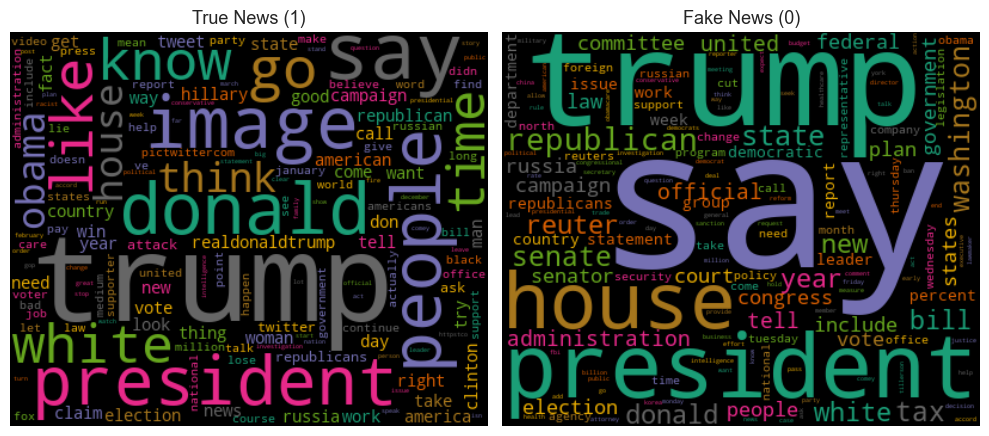

In [173]:
fig, axes = plt.subplots(1, 2, figsize=(10, 8))
k = 0
for i in range(0,1):
    for j in range(0,2):
        generate_wordcloud(df_dtm_text_label[labels[k]].sort_values(ascending=False), labels[k], axes[j])
        k+=1
axes = axes.flatten()
plt.tight_layout()
plt.show()

We can see most of the Fake News text are revolved around "trump","president" and "republican". True News mentions "people", "image" as well

#### 5.4 Distribution of Labels for each subject

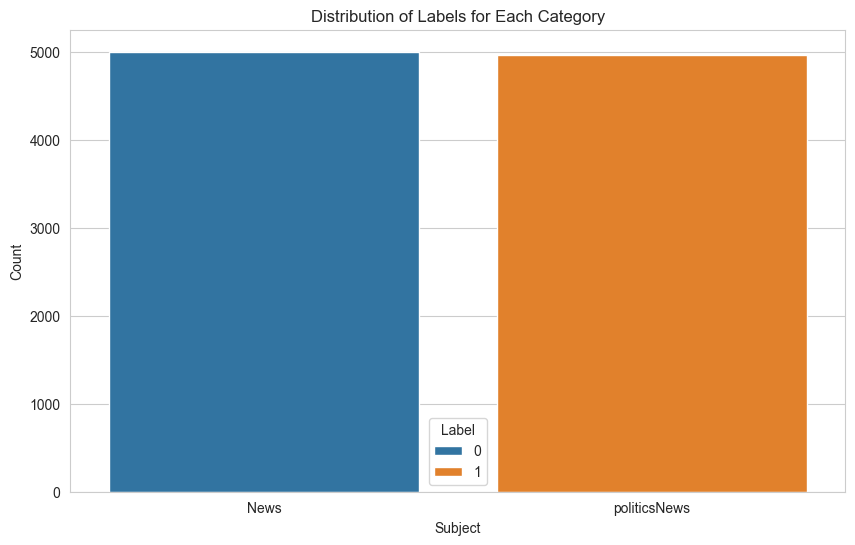

In [174]:
# Create the count plot
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='subject', hue='label')
plt.title('Distribution of Labels for Each Category')
plt.xlabel('Subject')
plt.ylabel('Count')
plt.legend(title='Label', labels=['0', '1'])
plt.show()

#### 5.5 Analayzing the Polarity of a sentence and seeing how that effects the news being real of Fake

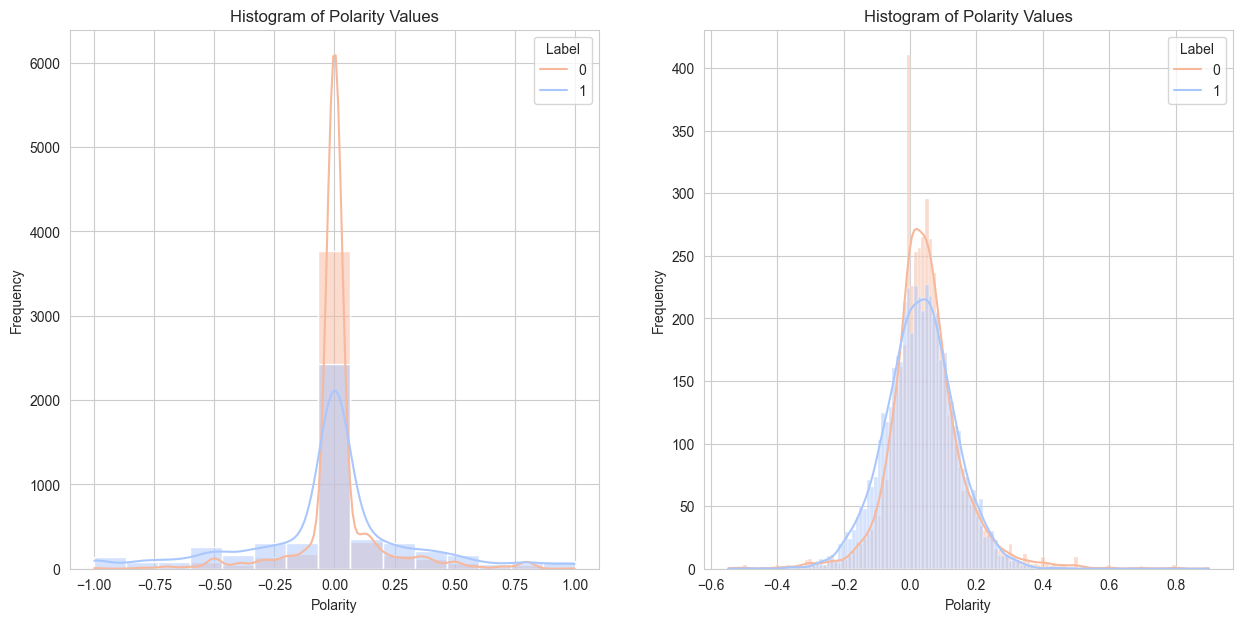

In [176]:
sns.set_style("whitegrid")

# Create a histogram with wave-like shape
fig, axs = plt.subplots(1, 2, figsize=(15, 7))
plt.subplot(121)
sns.histplot(data=df, x='polarity_title', hue='label',kde=True, palette='coolwarm')
plt.title('Histogram of Polarity Values')
plt.xlabel('Polarity')
plt.ylabel('Frequency')
plt.legend(title='Label', labels=['0', '1'], loc='upper right')
plt.subplot(122)
sns.histplot(data=df, x='polarity_text', hue='label',kde=True, palette='coolwarm')
plt.title('Histogram of Polarity Values')
plt.xlabel('Polarity')
plt.ylabel('Frequency')
plt.legend(title='Label', labels=['0', '1'], loc='upper right')
plt.show()

Polarity for title and text follow a normal distribution. With the normal distribution knowledge, you can use predictive modeling techniques that assume normality, such as linear regression or logistic regression. These models often yield reliable results when the underlying data conforms to a normal distribution.

## 6) Splitting Data into Train and Test Set

In [185]:
X = df.drop('label', axis=1) 
y = df['label']

In [186]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train =  y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

## 7) Feature Extraction and Data Transformation

#### 7.1 Vectorizing Text Columns using Embeddings

In [370]:
# Load pre-trained model and tokenizer
def get_embeddings(column_name,X):
    model_name = "bert-base-uncased"  # Example model name
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name)

    embeddings = []
    for text in X[column_name]:
        # Tokenize text
        inputs = tokenizer(text, return_tensors="pt",max_length=512, truncation=True, padding=True)

        # Generate embeddings
        with torch.no_grad():
            outputs = model(**inputs)
            last_hidden_states = outputs.last_hidden_state  # Extract embeddings from the last layer

        # Average pooling of embeddings (you can use other pooling strategies as well)
        pooled_embedding = last_hidden_states.mean(dim=1).squeeze().numpy()
        embeddings.append(pooled_embedding)
    
    return embeddings

In [191]:
# X_train['embeddings'] = get_embeddings('title',X_train)
# X_train.to_pickle('/Users/mansipandya/Desktop/FakeNewsDetection/data/dataframes/X_train_title_embed.pkl')


In [193]:
# X_train['embeddings_text'] = get_embeddings('text',X_train)
# X_train.to_pickle('/Users/mansipandya/Desktop/FakeNewsDetection/data/dataframes/X_train_text_embed.pkl')

In [195]:
X_train = pd.read_pickle('/Users/mansipandya/Desktop/FakeNewsDetection/data/dataframes/X_train_title_embed.pkl')

In [359]:
X_train = pd.read_pickle('/Users/mansipandya/Desktop/FakeNewsDetection/data/dataframes/X_train_text_embed.pkl')

In [361]:
X_train

,title,text,subject,date,polarity_title,polarity_text,embeddings,embeddings_text
0,viola davis give profound insight racial ten...,viola davis say issue racial tension america d...,News,"January 8, 2017",0.083333,0.063750,"[0.029194111, -0.09542704, 0.011930835, 0.0318...","[0.046992, -0.050507925, 0.7028416, -0.0203115..."
1,senate advance iran sanctions bill eye new rus...,washington reuter senate vote overwhelmingly w...,politicsNews,"June 7, 2017",0.136364,0.203391,"[0.05270605, -0.21099454, -0.24220657, 0.11705...","[-0.24107403, -0.14984323, 0.45163614, -0.1154..."
2,trump set alien crime hotline go exactly lik...,recently donald trump second major elect leade...,News,"April 27, 2017",0.095238,-0.109327,"[0.501284, -0.35964933, 0.33377698, 0.10506673...","[-0.03204977, 0.08029023, 0.58468246, -0.17510..."
3,house conservative say healthcare bill likely ...,washington reuter head house representative co...,politicsNews,"May 4, 2017",0.000000,0.325000,"[0.03746065, -0.47942528, 0.39928022, -0.14697...","[-0.14430414, -0.4698945, 0.39963087, -0.09025..."
4,america stepdad tim kaine burn trump hard co...,democratic vice presidential nominee tim kaine...,News,"August 26, 2016",-0.291667,0.008864,"[-0.153712, -0.25228804, 0.25941917, -0.010781...","[-0.08884303, 0.14147021, 0.56195205, -0.18795..."
...,...,...,...,...,...,...,...,...
7968,' win ' twitter bite trump head attack judge,day federal judge san francisco block allege p...,News,"April 26, 2017",0.800000,-0.015976,"[0.51366544, -0.32179812, 0.27723718, -0.02856...","[-0.14525124, -0.020434644, 0.58101195, 0.0140..."
7969,mnuchin say orderly liquidation fsoc report,washington reuter treasury secretary steven mn...,politicsNews,"October 13, 2017",0.000000,-0.032005,"[-0.14853589, -0.041747034, -0.055965394, -0.3...","[-0.12994143, -0.1556911, 0.3828723, 0.0832110..."
7970,economic growth partially offset deficit impac...,washington reuter republican tax bill generate...,politicsNews,"November 30, 2017",0.050000,0.112121,"[-0.06683677, -0.30261824, 0.07231354, 0.16561...","[-0.13316317, -0.17782004, 0.14573963, 0.15644..."
7971,virginia seek hold trump contempt ignore fed...,donald trump end bar state virginia hold conte...,News,"February 2, 2017",0.000000,0.002059,"[0.13192306, -0.17457384, 0.087483056, -0.2989...","[-0.09989216, 0.091489896, 0.6303442, -0.14470..."


#### 7.2 Dealing with the Categorical Column

We are dealing with nominal data, where order isn't necessary. Since the number of subjects are less we can use OHE.

In [362]:
encoder = ce.BinaryEncoder(cols=['subject'])
X_train_encoded = encoder.fit_transform(X_train['subject'])
X_train_concatenated = pd.concat([X_train, X_train_encoded], axis=1)

In [363]:
columns_to_drop = ['title', 'text','subject','date']
X_final_train = X_train_concatenated.drop(columns=columns_to_drop)

In [364]:
X_final_train

,polarity_title,polarity_text,embeddings,embeddings_text,subject_0,subject_1
0,0.083333,0.063750,"[0.029194111, -0.09542704, 0.011930835, 0.0318...","[0.046992, -0.050507925, 0.7028416, -0.0203115...",0,1
1,0.136364,0.203391,"[0.05270605, -0.21099454, -0.24220657, 0.11705...","[-0.24107403, -0.14984323, 0.45163614, -0.1154...",1,0
2,0.095238,-0.109327,"[0.501284, -0.35964933, 0.33377698, 0.10506673...","[-0.03204977, 0.08029023, 0.58468246, -0.17510...",0,1
3,0.000000,0.325000,"[0.03746065, -0.47942528, 0.39928022, -0.14697...","[-0.14430414, -0.4698945, 0.39963087, -0.09025...",1,0
4,-0.291667,0.008864,"[-0.153712, -0.25228804, 0.25941917, -0.010781...","[-0.08884303, 0.14147021, 0.56195205, -0.18795...",0,1
...,...,...,...,...,...,...
7968,0.800000,-0.015976,"[0.51366544, -0.32179812, 0.27723718, -0.02856...","[-0.14525124, -0.020434644, 0.58101195, 0.0140...",0,1
7969,0.000000,-0.032005,"[-0.14853589, -0.041747034, -0.055965394, -0.3...","[-0.12994143, -0.1556911, 0.3828723, 0.0832110...",1,0
7970,0.050000,0.112121,"[-0.06683677, -0.30261824, 0.07231354, 0.16561...","[-0.13316317, -0.17782004, 0.14573963, 0.15644...",1,0
7971,0.000000,0.002059,"[0.13192306, -0.17457384, 0.087483056, -0.2989...","[-0.09989216, 0.091489896, 0.6303442, -0.14470...",0,1


In [365]:
# Flatten the "embeddings" column
embedding_cols = [f'embedding_{i}' for i in range(768)]
embeddings_df = pd.DataFrame(X_final_train['embeddings'].to_list(), columns=embedding_cols)

# Flatten the "embeddings_text" column
embedding_text_cols = [f'embedding_text_{i}' for i in range(768)]
embedding_text_df = pd.DataFrame(X_final_train['embeddings_text'].to_list(), columns=embedding_text_cols)

# Concatenate the flattened embeddings with the original DataFrame
X_final_train = pd.concat([X_final_train, embeddings_df, embedding_text_df], axis=1)

# Drop the original "embedding" and "embedding_text" columns
X_final_train.drop(['embeddings', 'embeddings_text'], axis=1, inplace=True)

In [366]:
# X_final_train.to_pickle('/Users/mansipandya/Desktop/FakeNewsDetection/data/dataframes/X_final_train.pkl')

In [368]:
X_final_train = pd.read_pickle('/Users/mansipandya/Desktop/FakeNewsDetection/data/dataframes/X_final_train.pkl')

In [369]:
X_final_train

,polarity_title,polarity_text,subject_0,subject_1,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,...,embedding_text_758,embedding_text_759,embedding_text_760,embedding_text_761,embedding_text_762,embedding_text_763,embedding_text_764,embedding_text_765,embedding_text_766,embedding_text_767
0,0.083333,0.063750,0,1,0.029194,-0.095427,0.011931,0.031892,0.281544,-0.079860,...,-0.108983,-0.239727,0.299554,-0.009304,0.066175,-0.127203,-0.104489,-0.131715,0.041339,-0.256212
1,0.136364,0.203391,1,0,0.052706,-0.210995,-0.242207,0.117053,-0.095407,-0.593302,...,-0.066656,-0.063069,0.276039,0.054704,0.191448,-0.222364,-0.007859,-0.215373,-0.176889,0.000255
2,0.095238,-0.109327,0,1,0.501284,-0.359649,0.333777,0.105067,0.252218,-0.201935,...,-0.220380,-0.263976,-0.009972,0.126395,0.054987,-0.123241,-0.243958,-0.117663,-0.034799,-0.392702
3,0.000000,0.325000,1,0,0.037461,-0.479425,0.399280,-0.146973,0.021342,-0.372897,...,-0.056866,0.140087,0.116382,0.088303,0.238002,-0.078502,0.196452,0.033913,-0.103911,-0.137729
4,-0.291667,0.008864,0,1,-0.153712,-0.252288,0.259419,-0.010782,0.235832,-0.050786,...,-0.320081,-0.114882,0.247068,0.136943,0.008466,-0.106782,-0.262860,-0.121039,-0.106163,-0.221260
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7968,0.800000,-0.015976,0,1,0.513665,-0.321798,0.277237,-0.028570,0.210360,0.113919,...,-0.301676,-0.156239,0.197907,0.111155,-0.070759,-0.308948,-0.366688,-0.123269,-0.055911,-0.164068
7969,0.000000,-0.032005,1,0,-0.148536,-0.041747,-0.055965,-0.355590,0.047445,-0.064497,...,0.056460,-0.162133,-0.028938,-0.257288,0.138840,-0.342378,-0.179397,-0.127166,-0.136939,-0.196758
7970,0.050000,0.112121,1,0,-0.066837,-0.302618,0.072314,0.165611,0.411013,0.058307,...,0.026755,0.279838,0.277640,0.091030,0.396871,-0.256203,0.126480,-0.149383,-0.174046,-0.172996
7971,0.000000,0.002059,0,1,0.131923,-0.174574,0.087483,-0.298985,0.063968,-0.378117,...,-0.201430,-0.281011,0.315781,0.068123,0.017304,-0.234844,-0.352147,-0.144547,-0.190863,-0.116425


#### 7.3 Applying the changes to Test Data

In [373]:
def transform_test_data():
    X_test['embeddings'] = get_embeddings('title',X_test)
    X_test['embeddings_text'] = get_embeddings('text',X_test)
    encoder = ce.BinaryEncoder(cols=['subject'])
    X_test_encoded = encoder.fit_transform(X_test['subject'])  
    X_test_concatenated = pd.concat([X_test, X_test_encoded], axis=1)
    columns_to_drop = ['title', 'text','subject','date']
    X_final_test = X_test_concatenated.drop(columns=columns_to_drop)
    
    # Flatten the "embeddings" column
    embedding_cols = [f'embedding_{i}' for i in range(768)]
    embeddings_df = pd.DataFrame(X_final_test['embeddings'].to_list(), columns=embedding_cols)

    # Flatten the "embeddings_text" column
    embedding_text_cols = [f'embedding_text_{i}' for i in range(768)]
    embedding_text_df = pd.DataFrame(X_final_test['embeddings_text'].to_list(), columns=embedding_text_cols)

    # Concatenate the flattened embeddings with the original DataFrame
    X_final_test = pd.concat([X_final_test, embeddings_df, embedding_text_df], axis=1)

    # Drop the original "embedding" and "embedding_text" columns
    X_final_test.drop(['embeddings', 'embeddings_text'], axis=1, inplace=True)

    return X_final_test

In [374]:
# X_final_test = transform_test_data()
# X_final_test.to_pickle('/Users/mansipandya/Desktop/FakeNewsDetection/data/dataframes/X_final_test.pkl')

In [376]:
X_final_test = pd.read_pickle('/Users/mansipandya/Desktop/FakeNewsDetection/data/dataframes/X_final_test.pkl')

In [377]:
X_final_test

,polarity_title,polarity_text,subject_0,subject_1,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,...,embedding_text_758,embedding_text_759,embedding_text_760,embedding_text_761,embedding_text_762,embedding_text_763,embedding_text_764,embedding_text_765,embedding_text_766,embedding_text_767
0,0.500000,0.090595,0,1,0.107142,-0.504713,0.207017,-0.093190,0.394302,0.020203,...,0.002759,-0.233454,-0.007308,0.009698,0.130273,-0.225220,-0.244223,-0.111087,0.018776,-0.225958
1,0.000000,0.062838,1,0,0.275265,-0.002280,0.115787,-0.135625,0.532905,-0.111231,...,-0.095008,-0.334286,0.155304,0.010727,0.084649,-0.071673,-0.184429,-0.244441,-0.115467,-0.248690
2,-0.144444,-0.065679,0,1,0.151495,-0.211203,0.286139,-0.008732,0.137023,-0.181239,...,-0.021568,-0.344973,0.175655,0.092913,0.111886,-0.136127,-0.357397,-0.172166,-0.012153,-0.262410
3,0.578571,0.279579,0,1,-0.313720,-0.451013,-0.226468,0.043912,0.137780,-0.047220,...,-0.085804,0.011034,0.216141,0.091405,0.144005,-0.036796,-0.245754,-0.201638,-0.121226,-0.044549
4,0.400000,0.091753,0,1,0.207569,-0.079497,0.413596,-0.132769,0.118142,-0.302971,...,-0.307003,-0.359207,0.141360,0.175307,0.077583,-0.340806,-0.285023,-0.305867,-0.008943,-0.181877
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1989,0.212500,0.175000,1,0,0.690931,-0.337113,0.779024,0.045463,0.033499,-0.068996,...,-0.160167,-0.513864,0.210120,0.059200,0.022961,-0.036987,-0.302923,-0.143553,-0.132404,-0.203437
1990,0.000000,0.065741,1,0,0.432994,-0.137463,0.370065,-0.121789,-0.086807,-0.069332,...,-0.150864,-0.155153,0.019833,0.063078,0.056752,0.024386,-0.335846,-0.158039,-0.264799,-0.280558
1991,0.000000,0.036508,1,0,0.028937,0.039568,0.029610,-0.025896,-0.017460,-0.156143,...,-0.174092,-0.156895,0.425112,0.147197,0.141968,-0.036193,-0.468439,-0.063537,-0.156995,-0.231185
1992,-0.179167,0.106107,1,0,0.233978,0.093801,0.265183,0.011575,-0.020055,-0.444892,...,-0.295790,-0.339034,0.215287,0.217068,-0.034420,0.094512,-0.383856,-0.144700,-0.151292,-0.080505


## 8) Model Training and Evaluation

##### 8.1 Importing Preprocessed Data

In [ ]:
X_final_train = pd.read_pickle('/Users/mansipandya/Desktop/FakeNewsDetection/data/dataframes/X_final_train.pkl')
X_final_test = pd.read_pickle('/Users/mansipandya/Desktop/FakeNewsDetection/data/dataframes/X_final_test.pkl')

In [378]:
print(X_final_train.shape)
print(y_train.shape)
print(X_final_test.shape)
print(y_test.shape)

(7973, 1540)
(7973,)
(1994, 1540)
(1994,)


In [ ]:
y_test = y_test.values

#### 8.2 Models to Experiment with

- Logistic Regression
- Decision Trees
- Random Forests
- Gradient Boosting Machines (GBM)
- Support Vector Machines (SVM)
- K-Nearest Neighbors (KNN)
- Neural Networks
- XGBoost
- LightGBM
- CatBoost

#### 8.3 Common Functions

In [589]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn import metrics

def evaluate(y_truth, y_pred):
    accuracy = metrics.accuracy_score(y_truth, y_pred)
    print("accuracy:   %0.3f" % accuracy)
    prf = classification_report(y_truth, y_pred)
    cm = confusion_matrix(y_truth,y_pred)
    print("Classification Report:")
    print(prf)
    tn, fp, fn, tp = confusion_matrix(y_truth,y_pred).ravel()
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=['Fake News', 'Real News'], yticklabels=['Fake News', 'Real News'])
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()
    print("True Negative",tn)
    print("False Positive",fp)
    print("False Negative",fn)
    print("True Positive",tp)
    
    return accuracy, prf, cm, tn, fp, fn, tp

#### 8.4 Logistic Regression

In [590]:
from sklearn.linear_model import LogisticRegression

logistic_regression_model = LogisticRegression()
logistic_regression_model.fit(X_final_train, y_train)
y_pred = logistic_regression_model.predict(X_final_test)

accuracy:   0.621
Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.64      0.63      1006
           1       0.62      0.60      0.61       988

    accuracy                           0.62      1994
   macro avg       0.62      0.62      0.62      1994
weighted avg       0.62      0.62      0.62      1994



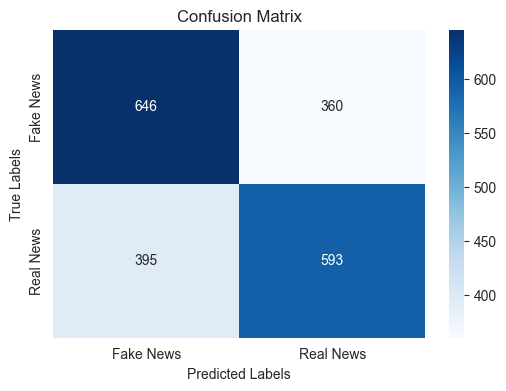

True Negative 646
False Positive 360
False Negative 395
True Positive 593


In [591]:
accuracy, prf, cm, tn, fp, fn, tp = evaluate(y_test, y_pred)

#### 8.2 Decision Trees

In [592]:
from sklearn.tree import DecisionTreeClassifier

tree_model = DecisionTreeClassifier()
tree_model.fit(X_final_train, y_train)
y_pred = tree_model.predict(X_final_test)

accuracy:   0.000
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00    1006.0
           1       0.00      0.00      0.00     988.0

    accuracy                           0.00    1994.0
   macro avg       0.00      0.00      0.00    1994.0
weighted avg       0.00      0.00      0.00    1994.0



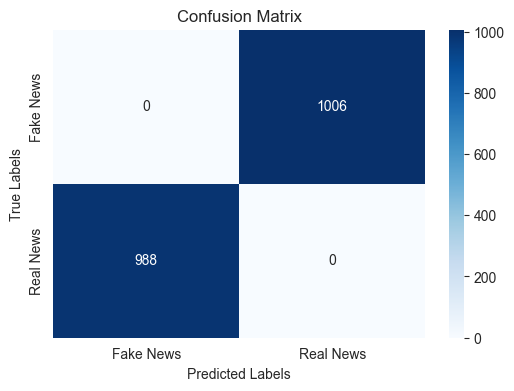

True Negative 0
False Positive 1006
False Negative 988
True Positive 0


In [593]:
accuracy, prf, cm, tn, fp, fn, tp = evaluate(y_test, y_pred)

##### 8.3 Random Forest

In [594]:
from sklearn.ensemble import RandomForestClassifier

forest_model = RandomForestClassifier()
forest_model.fit(X_final_train, y_train)
y_pred = forest_model.predict(X_final_test)

accuracy:   0.365
Classification Report:
              precision    recall  f1-score   support

           0       0.03      0.01      0.01      1006
           1       0.42      0.73      0.53       988

    accuracy                           0.36      1994
   macro avg       0.23      0.37      0.27      1994
weighted avg       0.22      0.36      0.27      1994



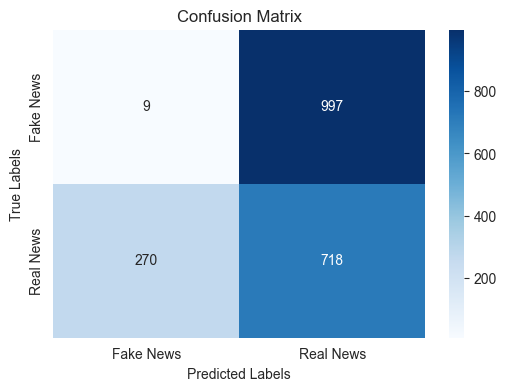

True Negative 9
False Positive 997
False Negative 270
True Positive 718


In [595]:
accuracy, prf, cm, tn, fp, fn, tp = evaluate(y_test, y_pred)

#### 8.4 Gradient Boosting Machines (GBM)

In [596]:
from sklearn.ensemble import GradientBoostingClassifier

gbm_model = GradientBoostingClassifier()
gbm_model.fit(X_final_train, y_train)
y_pred = gbm_model.predict(X_final_test)

accuracy:   0.000
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00    1006.0
           1       0.00      0.00      0.00     988.0

    accuracy                           0.00    1994.0
   macro avg       0.00      0.00      0.00    1994.0
weighted avg       0.00      0.00      0.00    1994.0



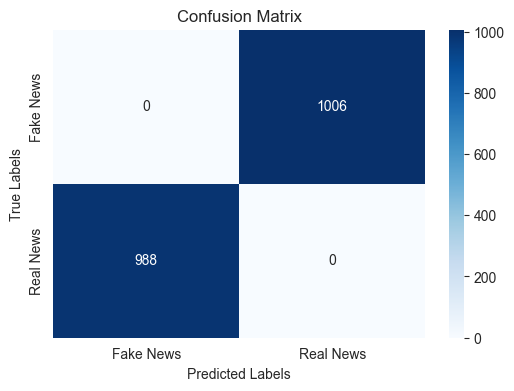

True Negative 0
False Positive 1006
False Negative 988
True Positive 0


In [597]:
accuracy, prf, cm, tn, fp, fn, tp = evaluate(y_test, y_pred)

#### 8.5 Support Vector Machines (SVM)

In [599]:
from sklearn.svm import SVC

svm_model = SVC()
svm_model.fit(X_final_train, y_train)
y_pred = svm_model.predict(X_final_test)

accuracy:   0.009
Classification Report:
              precision    recall  f1-score   support

           0       0.01      0.00      0.01      1006
           1       0.01      0.01      0.01       988

    accuracy                           0.01      1994
   macro avg       0.01      0.01      0.01      1994
weighted avg       0.01      0.01      0.01      1994



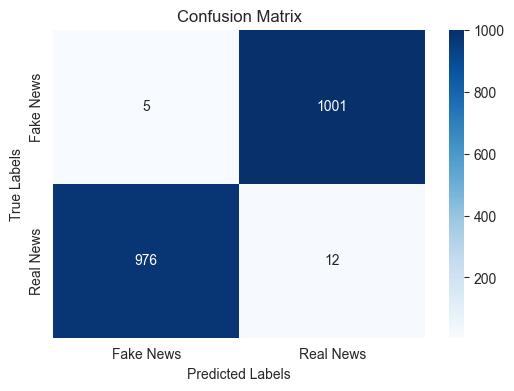

True Negative 5
False Positive 1001
False Negative 976
True Positive 12


In [600]:
accuracy, prf, cm, tn, fp, fn, tp = evaluate(y_test, y_pred)

#### 8.6 K-Nearest Neighbors (KNN)


In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn_model = KNeighborsClassifier()
knn_model.fit(X_train, y_train)
y_pred = knn_model.predict(X_test)

In [ ]:
accuracy, prf, cm, tn, fp, fn, tp = evaluate(y_test, y_pred)

##### 8.7 Neural Networks

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Define the model
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))


In [ ]:
accuracy, prf, cm, tn, fp, fn, tp = evaluate(y_test, y_pred)

#### 8.8 XGBoost

In [546]:
import xgboost as xgb

model = xgb.XGBClassifier()
model.fit(X_train, y_train)
preds = model.predict(X_test)

In [ ]:
accuracy, prf, cm, tn, fp, fn, tp = evaluate(y_test, y_pred)

#### 8.9 LightGBM

In [ ]:
import lightgbm as lgb

model = lgb.LGBMClassifier()
model.fit(X_train, y_train)
preds = model.predict(X_test)


In [ ]:
accuracy, prf, cm, tn, fp, fn, tp = evaluate(y_test, y_pred)

#### 8.10 Catboost

In [ ]:
from catboost import CatBoostClassifier

model = CatBoostClassifier()
model.fit(X_train, y_train)
preds = model.predict(X_test)


In [ ]:
accuracy, prf, cm, tn, fp, fn, tp = evaluate(y_test, y_pred)

## 10) Model Tuning

In [302]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'] 
}

grid_search = GridSearchCV(estimator=logistic_regression_model, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_final_train, y_train) 

In [487]:
print("Best hyperparameters:", grid_search.best_params_)

Best hyperparameters: {'C': 0.1, 'penalty': 'l2'}


In [307]:
best_model = grid_search.best_estimator_

In [308]:
y_pred = best_model.predict(X_final_test) 

In [309]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.72      0.72      0.72      1006
           1       0.72      0.72      0.72       988

    accuracy                           0.72      1994
   macro avg       0.72      0.72      0.72      1994
weighted avg       0.72      0.72      0.72      1994



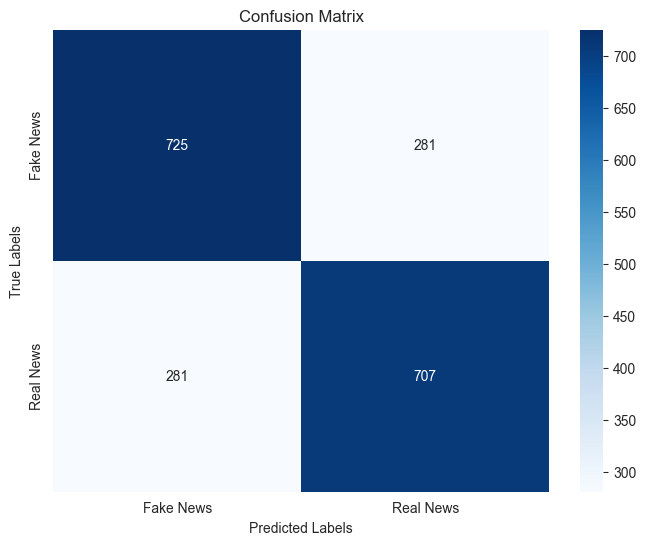

725 281 281 707


In [311]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test,y_pred)
tn, fp, fn, tp = confusion_matrix(y_test,y_pred).ravel()
# Create a heatmap for visualization
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=['Fake News', 'Real News'], yticklabels=['Fake News', 'Real News'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
print(tn, fp, fn, tp)

We can see that the performance has definately improved

True Positives (TP): For 707 data points Real News was predicted as Real News

True Negatives (TN): For 725 data points Fake News was predicted as Fake News

False Positives (FP): For 281 data points the model incorrectly predicted the Real News when it's actually Fake News. (Type I error)

False Negatives (FN): For 281 data points the model incorrectly predicted the Fake News when it's actually Real News. (Type II error)

## 10) Model Selection

#### 10.1 Test on Unseen Data to Validate the Model

In [537]:
data_point = fake.iloc[13021:13022]
data_point.reset_index(drop=True, inplace=True)

In [538]:
data_point

,title,text,subject,date,label
0,HOW HILLARY DESTROYED This Man’s Life To Hide ...,Does anyone even care that this American man w...,politics,"Sep 14, 2016",0


In [539]:
def predict_function(df):
    df.drop(columns=['label','date'], inplace=True)
    columns = ['title','text']
    for col in columns:
        f'embedding_{i}'
        df[f'polarity_{col}']=df[col].apply(lambda x:TextBlob(x).sentiment.polarity)
        df[col]=df[col].apply(lambda x: x.lower())
        df[col]=df[col].apply(lambda x: re.sub('\w*\d\w*','', x))
        df[col]=df[col].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '', x))
        df[col]=df[col].apply(lambda x: re.sub(' +',' ',x))
        df[col]=df[col].apply(lambda x: ' '.join([token.lemma_ for token in list(nlp(x)) if (token.is_stop==False)]))

    df['embeddings'] = get_embeddings('title',df)
    df['embeddings_text'] = get_embeddings('text',df)
    
    encoder = ce.BinaryEncoder(cols=['subject'])
    df_encoded = encoder.fit_transform(df['subject'])  
    df_concatenated = pd.concat([df, df_encoded], axis=1)

    columns_to_drop = ['title', 'text','subject']
    df_final = df_concatenated.drop(columns=columns_to_drop)

    embedding_cols = [f'embedding_{i}' for i in range(768)]
    embeddings_df = pd.DataFrame(df_final['embeddings'].to_list(), columns=embedding_cols)
    embedding_text_cols = [f'embedding_text_{i}' for i in range(768)]
    embedding_text_df = pd.DataFrame(df_final['embeddings_text'].to_list(), columns=embedding_text_cols)
    df_final = pd.concat([df_final, embeddings_df, embedding_text_df], axis=1)
    df_final.drop(['embeddings', 'embeddings_text'], axis=1, inplace=True)

    if 'subject_0' in df_final.columns:
        df_final['subject_1'] = 0
        column1_index = df_final.columns.get_loc('subject_0') + 1 
        column2_index = df_final.columns.get_loc('embedding_0')
        df_final.insert(column2_index, 'subject_1', df_final.pop('subject_1'))
    return df_final

In [540]:
df_final = predict_function(data_point)

In [541]:
df_final

,polarity_title,polarity_text,subject_0,subject_1,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,...,embedding_text_758,embedding_text_759,embedding_text_760,embedding_text_761,embedding_text_762,embedding_text_763,embedding_text_764,embedding_text_765,embedding_text_766,embedding_text_767
0,0.0,-0.069716,1,0,0.047114,-0.062232,0.012871,-0.204165,0.113709,-0.196935,...,-0.132606,-0.176794,0.144439,0.007566,0.08691,-0.070113,-0.334315,-0.111324,-0.130219,-0.189157


In [536]:
# Predict 
best_model.predict(df_final)

array([0])

Thus, We can see that the model predicts accurately on unseen data

#### 10.2 Pickle and Load the Model

In [485]:
import pickle

with open('/Users/mansipandya/Desktop/FakeNewsDetection/data/models/model.pkl', 'wb') as f:
    pickle.dump(best_model, f)

In [486]:
# Load the saved model from the file
with open('/Users/mansipandya/Desktop/FakeNewsDetection/data/models/model.pkl', 'rb') as f:
    loaded_model = pickle.load(f)